# Image Segmentation using Keras

In this tutorial you will see how to setup a simple model for image segmentation using the popular
[PASCAL VOC dataset](http://host.robots.ox.ac.uk/pascal/VOC/)
([mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/)). For each pixel in the image we will try to predict if the pixel is foreground or background.

In [138]:
from pathlib import Path
from tqdm import tqdm
import os
import keras

More tutorials at https://github.com/fchollet/keras-resources

# Prelude

Keras has a prefered way of storing image datasets. PASCAL VOC comes with a different layout so we first have to rearrange some things.

# Load Data

* Load PASCAL VOC
* Split into train, test (80/20)
* Show some examples
* Calculate mean/std of input (normalised input is a Good Thing&trade;)

In [184]:
voc_tarfile = keras.utils.get_file(
    fname='VOCtrainval_11-May-2012.tar',
    origin='http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar',
    extract=True,
    file_hash='e14f763270cf193d0b5f74b169f44157a4b0c6efa708f4dd0ff78ee691763bcb')
voc = Path(voc_tarfile).parent / 'VOCdevkit' / 'VOC2012'

In [187]:
# voc = Path('...')

In [4]:
trainset = [id_.strip() for id_ in open(voc / 'ImageSets' / 'Segmentation' / 'train.txt')]
valset = [id_.strip() for id_ in open(voc / 'ImageSets' / 'Segmentation' / 'val.txt')]

In [6]:
def create_image_folders(image_ids, root_folder):
    image_dir = Path(root_folder) / 'image' / 'dummy'
    mask_dir = Path(root_folder) / 'mask' / 'dummy'

    os.makedirs(image_dir)
    os.makedirs(mask_dir)

    for image in tqdm(image_ids, desc='linking images'):
        image_src = voc / 'JPEGImages' / f'{image}.jpg'
        image_dst = image_dir / f'{image}.jpg'
        os.symlink(image_src, image_dst)

        mask_src = voc / 'SegmentationClass' / f'{image}.png'
        mask_dst = mask_dir / f'{image}.png'
        os.symlink(mask_src, mask_dst)

create_image_folders(trainset, 'data/train')
create_image_folders(valset, 'data/val')

FileExistsError: [Errno 17] File exists: 'data/train/image/dummy'

In [44]:
imgen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

In [114]:
def categories_to_foreground_mask(categories):
    foreground = categories.sum(axis=-1) != 0.0
    return foreground.reshape(foreground.shape + (1,)).astype('float32')

maskgen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=categories_to_foreground_mask)

In [144]:
target_size = (256, 256)
im = imgen.flow_from_directory('data/train/image',
                               target_size=target_size,
                               batch_size=1,
                               shuffle=True,
                               seed=4,
                               class_mode=None)[0]
ma = maskgen.flow_from_directory('data/train/mask',
                                 color_mode='grayscale',
                                 target_size=target_size,
                                 batch_size=1,
                                 shuffle=True,
                                 seed=4,
                                 class_mode=None)[0]

Found 1464 images belonging to 1 classes.
Found 1464 images belonging to 1 classes.


In [145]:
import matplotlib.pyplot as plt

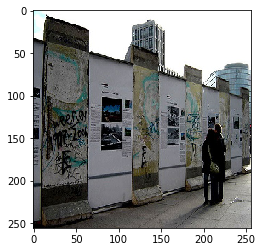

In [146]:
plt.imshow(im[0, ...])
plt.show()

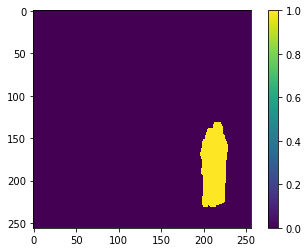

In [147]:
plt.imshow(ma[0, ..., 0])
plt.colorbar()
plt.show()

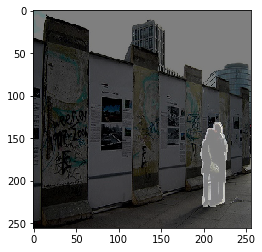

In [148]:
plt.imshow(0.5 * im[0, ...] + 0.5 * ma[0, ...])
plt.show()

# Define Model

Super simple U-Net

Ref: https://keras.io/getting-started/functional-api-guide/

In [125]:
# Shortcuts make it more readable.
Input = keras.layers.Input
Conv2D = keras.layers.Conv2D
AveragePooling2D = keras.layers.AveragePooling2D
UpSampling2D = keras.layers.UpSampling2D
BatchNormalization = keras.layers.BatchNormalization
Activation = keras.layers.Activation

In [126]:
image = Input(shape=[256, 256, 3], name='image')

x = Conv2D(filters=16, kernel_size=(3, 3), padding='same')(image)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x_large = x
x_small = AveragePooling2D(pool_size=(2, 2))(x)

x = Conv2D(32, (3, 3), padding='same')(x_small)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x_upsampled = UpSampling2D(size=(2, 2))(x)
x = keras.layers.concatenate([x_large, x_upsampled])

x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

logits = Conv2D(1, (1, 1), padding='same', name='logit')(x)
prediction = Activation('sigmoid', name='prediction')(logits)

model = keras.models.Model(inputs=image, outputs=prediction)

In [127]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 256, 256, 16) 448         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 256, 256, 16) 64          conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 256, 256, 16) 0           batch_normalization_13[0][0]     
__________________________________________________________________________________________________
average_po

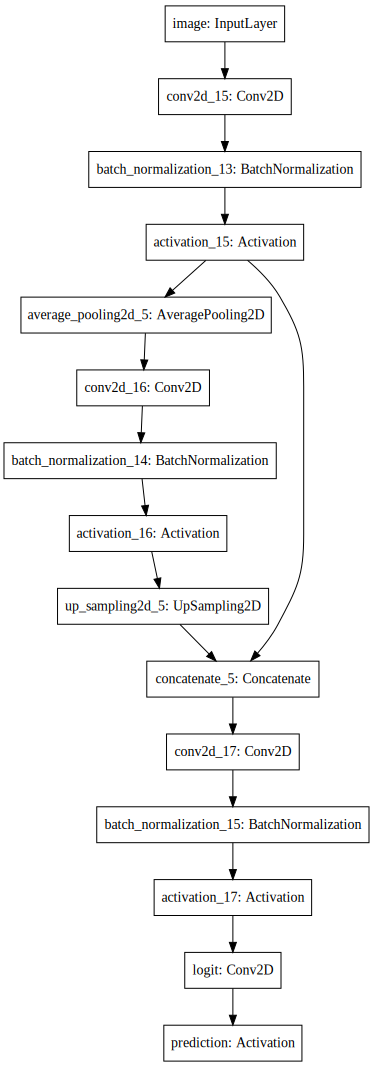

In [128]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Compile Model

In [129]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit Model

In [130]:
class ZipSequence(keras.utils.Sequence):
    def __init__(self, a, b):
        if len(a) != len(b):
            raise ValueError('length of both sequences must be equal: '
                             '{} vs. {}'.format(len(a), len(b)))
        self.a = a
        self.b = b

    def __len__(self):
        return len(self.a)

    def __getitem__(self, idx):
        return self.a[idx], self.b[idx]

In [133]:
image_gen = imgen.flow_from_directory('data/train/image', target_size=target_size, shuffle=False, class_mode=None)
mask_gen = maskgen.flow_from_directory('data/train/mask', color_mode='grayscale', target_size=target_size, shuffle=False, class_mode=None)
input_gen = ZipSequence(image_gen, mask_gen)

Found 1464 images belonging to 1 classes.
Found 1464 images belonging to 1 classes.


In [134]:
model.fit_generator(input_gen)

Epoch 1/1
46/46 [==============================] - 486s 11s/step - loss: 0.5912 - acc: 0.6915


# Evaluate Model

In [135]:
image_gen = imgen.flow_from_directory('data/val/image', target_size=target_size, shuffle=False, class_mode=None)
mask_gen = maskgen.flow_from_directory('data/val/mask', color_mode='grayscale', target_size=target_size, shuffle=False, class_mode=None)
input_gen = ZipSequence(image_gen, mask_gen)

model.evaluate_generator(input_gen)

Found 1449 images belonging to 1 classes.
Found 1449 images belonging to 1 classes.


[0.58686174163331317, 0.67875646109248622]

In [136]:
model.metrics_names

['loss', 'acc']

In [149]:
%%time

predictions = model.predict_generator(input_gen, steps=1)

CPU times: user 13.1 s, sys: 4.09 s, total: 17.2 s
Wall time: 5.2 s


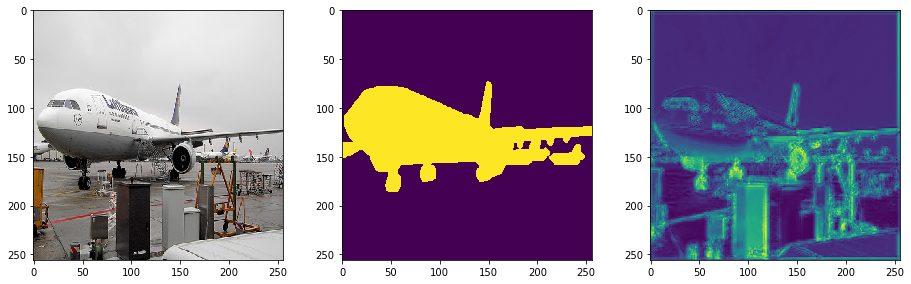

In [181]:
f, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(13,4))
im = ax3.imshow(predictions[0,...,0])
# f.colorbar(im)

im, ma = input_gen[0]

ax1.imshow(im[0,...])
ax2.imshow(ma[0,...,0])
plt.tight_layout()
plt.show(f)

## Extension Options

* Implement a better network
* Try data augmentation
* Implement data augmentation from U-Net paper
* Make the ambiguous class == 0.5.